<a href="https://colab.research.google.com/github/p-medeiros/Crypto-Currency-Prediction/blob/main/PrevisaoDoValorEMovimentoDeCryptomoedas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O codigo a seguir ira utlizar duas metodologias. Regressão logistica e Regrassão linear multipla, pra calcular se a moeda vai subir ou cair em valor, e o proximo valor, respectivamente.
O Codigo utliza a tabela CSV do site "https://br.investing.com/crypto/bitcoin/btc-usd-historical-data" que fornece a tabela com dados de diversas Moedas. E para esse codigo, sera usado o Bitcoin, no periodo de 25/01/2022 até 25/02/2023.
O arquivo para teste segue em anexo com o envio do trabalho.

In [ ]:
!pip install sklearn.metrics

ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
#Importar Bibliotecas

import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline
pd.options.display.max_rows = 50

In [ ]:
#Abri drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Acessar arquivo
#Documento csv contem os dados diarios de um ano do Bitcoin
caminho = '/content/drive/MyDrive/Colab Notebooks/Dados1AnosD.csv'
dados = pd.read_csv(caminho, decimal = ',')

In [ ]:
dados.dtypes

In [ ]:
dados

In [ ]:
#Corrigir formato dos dados, coluna Var% considerando o simbolo %, Coluna Vol. considerando as identificações K,M,B,
#e restantes corrigindo apenas a questao dos decimais
dados['Var%'] = dados['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

corrigir =  ['Último','Abertura','Máxima','Mínima']
for i in corrigir:
    dados[i] = dados[i].str.replace(".", "")
for i in corrigir:
    dados[i] = dados[i].str.replace(",", ".").astype(float)

dados['Vol.'] = dados['Vol.'].str.replace(',', '.').str.replace('K', 'E3').str.replace('M', 'E6').str.replace('B', 'E9')
dados['Vol.'] = pd.to_numeric(dados['Vol.'])
dados

In [ ]:
#Criar a coluna Outcome para futura analize logistica, onde 1 indica que no dia seguinte o preço subiu (1) ou caiu (0)
dados['Outcome'] = 0

for i in range(1, len(dados)):
    var_anterior = dados.at[i-1, 'Var%']
    if var_anterior > 0:
        dados.at[i, 'Outcome'] = 1
    else:
        dados.at[i, 'Outcome'] = 0

In [ ]:
dados.dtypes

In [ ]:
#Inverter a tabela para ordem Cronologica
dados = dados[::-1]

In [ ]:
#Difinir a coluna data com o Indice
dados = dados.set_index('Data')

In [ ]:
dados

In [ ]:
dados.describe()

In [ ]:
dados.isnull().sum()

Para obter maior precisão, podemos calcular os indicadores comuns que são ultilizados para analizar tendencias de alta e baixa. Os indicadores que serão calculados são: **IRF(Indice de força relativa)**; **Media Movel**; **Bandas de Bollinger**.


In [ ]:
#Calculo de indicadores
    #IRF
dados['Variacao'] = dados['Último'].diff()
dados['Ganho'] = np.where(dados['Variacao'] > 0, dados['Variacao'], 0)
dados['Perda'] = np.where(dados['Variacao'] < 0, dados['Variacao'], 0)

n = 14
simple_avg_gain = dados['Ganho'].rolling(n).mean()
simple_avg_loss = dados['Perda'].abs().rolling(n).mean()

classic_avg_gain = simple_avg_gain.copy()
classic_avg_loss = simple_avg_loss.copy()


for i in range(n, len(classic_avg_gain)):
    classic_avg_gain[i] = (classic_avg_gain[i - 1] * (n - 1) + dados['Ganho'].iloc[i]) / n
    classic_avg_loss[i] = (classic_avg_loss[i - 1] * (n - 1) + dados['Perda'].abs().iloc[i]) / n

dados['FRS'] = simple_avg_gain / simple_avg_loss #Força relativa simples
dados['FRC'] = classic_avg_gain / classic_avg_loss#Força relativa Classica

dados['I FRS'] = 100 - (100 / (1 + dados['FRS']))#Indice de força relativa simples
dados['I FRC'] = 100 - (100 / (1 + dados['FRC']))#Indice de força relativa classica


dados

In [ ]:
#Calculo de indicadores
    #Media Movel
dados['MM21'] = dados['Último'].rolling(21).mean()
dados['MME9'] = dados['Último'].ewm(span=9, min_periods=9).mean()


In [ ]:
#calculo de indicadores
    #Bandas de Bollinger
N = 20 # Periodo da Media Movel
k = 2  # Fator de troca de banda

dados['DesvioP'] = dados['Último'].rolling(N).std()
dados['BandaM'] = dados['Último'].rolling(N).mean()
dados['BandaS'] = dados['BandaM'] + dados['DesvioP'] * k
dados['BandaI'] = dados['BandaM'] - dados['DesvioP'] * k

In [ ]:
dados

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    nrows=5,
    sharex=True,
    figsize=(20,16),
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 3]})
#Preco
ax1.set_title("Bitcoin")
ax1.plot(dados.index, dados['Último'], label='Fechamento')
ax1.legend()
#MM21
ax2.set_title("MM21")
ax2.plot(dados.index, dados['MM21'], label='MM21', color="#033660")
ax2.legend()
#MME9
ax3.set_title("MME9")
ax3.plot(dados.index, dados['MME9'], label='MME9', color="#033660")
ax3.legend()
#IRF
ax4.set_title("IRF")
ax4.plot(dados.index, dados['I FRC'], label='IFR', color="#033660")
ax4.axhline(y=70, color='white', linestyle='--')
ax4.axhline(y=30, color='white', linestyle='--')
ax4.axhspan(30, 70, color='indigo', alpha=0.2)
ax4.set_ylim(0, 100)
ax4.legend()
#Banda
ax5.set_title("Banda de Bollinger")
dados['Último'].plot(ax=ax5, label='Fechamento')
dados['BandaS'].plot(ax=ax5, linewidth=0.5, label='BandaS')
dados['BandaI'].plot(ax=ax5, linewidth=0.5, color="#033660", label='BandaI')
dados['BandaM'].plot(ax=ax5, linewidth=0.5, color="#033660", linestyle="dashed", label='BandaM')
ax5.set_xticks([])
ax5.legend()

In [ ]:
#Mover Coluna outcome para o final da tabela
coluna = dados.pop('Outcome')
dados.insert(len(dados.columns), coluna.name, coluna)
dados

In [ ]:
dados.isnull().sum()

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(dados.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
dados = dados.dropna()

In [ ]:
dados.isnull().sum()

In [ ]:
#Dividir dados independentes
x_dados = dados.iloc[:, 0:19]
x_dados

In [ ]:
#Dividir dados dependentes
y_dados = dados.iloc[:, 19]
y_dados

In [ ]:
scaler_dados = StandardScaler()
x_dados = scaler_dados.fit_transform(x_dados)
x_dados

In [ ]:
x_dados_treinamento, x_dados_teste, y_dados_treinamento, y_dados_teste = train_test_split(x_dados, y_dados, test_size = 0.2, random_state = 0)

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(x_dados_treinamento,y_dados_treinamento)

In [ ]:
predictions = logmodel.predict(x_dados_teste)

In [ ]:
print(classification_report(y_dados_teste,predictions))

A Regressão Logistica atingiu 63% de precisâo, esse valor ocorre pois apesar de indicadores serem importantes para a previsão do valor, variaves sociais e politicas tem forte influencia no valor. Um codigo que considere, por exemplo, se as noticias sobre a moeda sao positivas ou negativas, pode obter um melhor resultado.


Outra Metodologia viavel é a regressão linear multipla.

In [ ]:
#Criar uma nova coluna com o valor futuro da moeda
dados['ValorFuturo'] = dados['Último'].shift(-1)

In [ ]:
dados.isnull().sum()

In [ ]:
#A ultima linha nao tera valor futuro registrado então sera retirada
dados = dados.dropna()

In [ ]:
dados.isnull().sum()

In [ ]:
#Nao inclui a coluna
x_dados = dados.iloc[:, 0:19]
x_dados

In [ ]:
#Agora a variavel dependente é coluna ValorFuturo, nao a outcome
y_dados = dados.iloc[:, 20]
y_dados

In [ ]:
scaler_dados = StandardScaler()
x_dados = scaler_dados.fit_transform(x_dados)
x_dados

In [ ]:
x_dados_treinamento, x_dados_teste, y_dados_treinamento, y_dados_teste = train_test_split(x_dados, y_dados, test_size = 0.2, random_state = 0)

In [ ]:
regressor_multiplo_dados = LinearRegression()
regressor_multiplo_dados.fit(x_dados_treinamento, y_dados_treinamento)

In [ ]:
regressor_multiplo_dados.intercept_

In [ ]:
regressor_multiplo_dados.coef_

In [ ]:
regressor_multiplo_dados.score(x_dados_treinamento, y_dados_treinamento)

In [ ]:
regressor_multiplo_dados.score(x_dados_teste, y_dados_teste)

In [ ]:
predictions = regressor_multiplo_dados.predict(x_dados_teste)
predictions

In [ ]:
mae = mean_absolute_error(y_dados_teste, predictions)
mse = mean_squared_error(y_dados_teste, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

MAE: 565.2741286475836
MSE: 621332.6615692234
RMSE: 788.2465740929189


In [ ]:
graph = regressor_multiplo_dados.predict(x_dados)
graph_series = pd.Series(graph)

[]

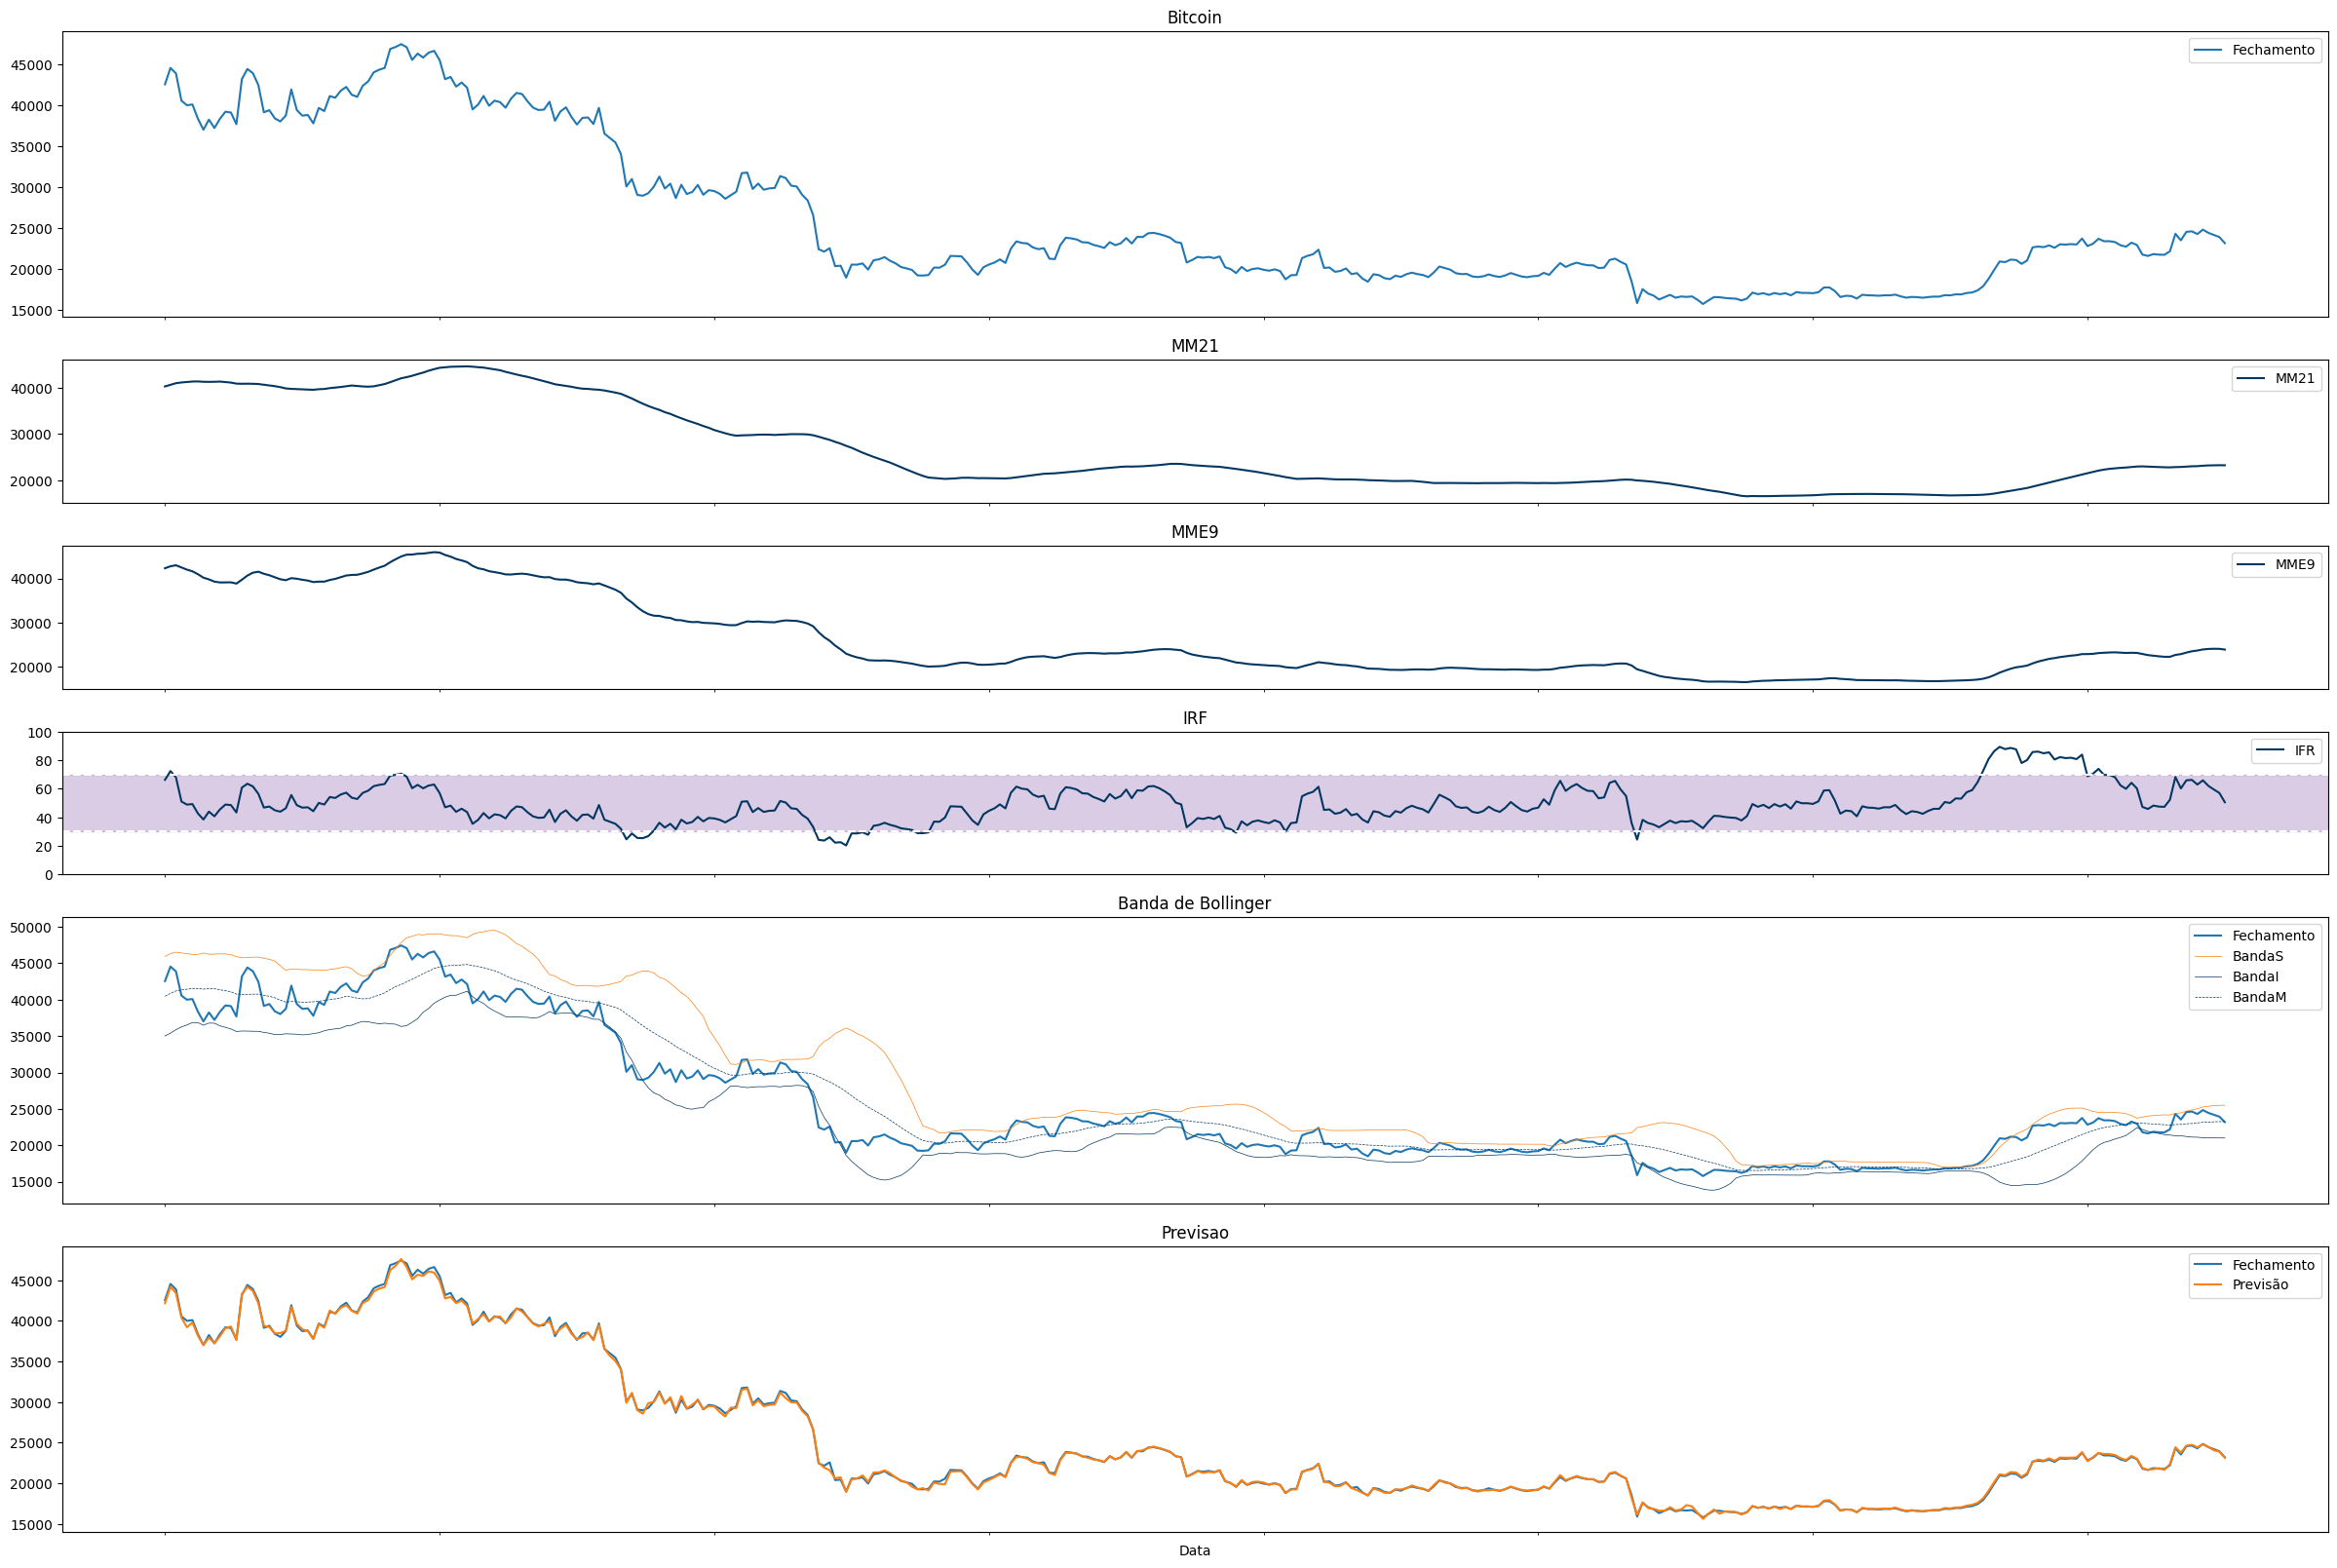

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(
    nrows=6,
    sharex=True,
    figsize=(30,20),
    gridspec_kw={'height_ratios': [2, 1, 1, 1, 2, 2]})
#Preco
ax1.set_title("Bitcoin")
ax1.plot(dados.index, dados['Último'], label='Fechamento')
ax1.legend()
#MM21
ax2.set_title("MM21")
ax2.plot(dados.index, dados['MM21'], label='MM21', color="#033660")
ax2.legend()
#MME9
ax3.set_title("MME9")
ax3.plot(dados.index, dados['MME9'], label='MME9', color="#033660")
ax3.legend()
#IRF
ax4.set_title("IRF")
ax4.plot(dados.index, dados['I FRC'], label='IFR', color="#033660")
ax4.axhline(y=70, color='white', linestyle='--')
ax4.axhline(y=30, color='white', linestyle='--')
ax4.axhspan(30, 70, color='indigo', alpha=0.2)
ax4.set_ylim(0, 100)
ax4.legend()
#Banda
ax5.set_title("Banda de Bollinger")
dados['Último'].plot(ax=ax5, label='Fechamento')
dados['BandaS'].plot(ax=ax5, linewidth=0.5, label='BandaS')
dados['BandaI'].plot(ax=ax5, linewidth=0.5, color="#033660", label='BandaI')
dados['BandaM'].plot(ax=ax5, linewidth=0.5, color="#033660", linestyle="dashed", label='BandaM')
ax5.legend()
#Previsão
ax6.set_title("Previsao")
dados['Último'].plot(ax=ax6, label='Fechamento')
graph_series.plot(ax=ax6, linewidth=1.5, label='Previsão')
ax6.legend()
ax6.set_xticks([])

O codigo de Regrassão linear multipla se adaptou bem com pontuação de 98%. Porem obteve um valor de erro muito alem do ideal.
Logo apesar de acompanhar bem a linha, não é tão preciso.

In [ ]:
%pip install  hls4ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.3/572.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4915 sha256=6f541fd5febb0ca6d15d799f968f8113c3b06dea3c08a10de69936c5c151dd00
  Stored in directory: /root/.cache/pip/wheels/25/87/78/ff95e8a747dc534fbd199fb3ea06d80935bc87e44567bbdb31
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18155 sha256=b3

In [ ]:
import hls4ml

In [ ]:
config = hls4ml.model.HLSConfig.from_json('/content/sample_data/anscombe.json')

AttributeError: type object 'HLSConfig' has no attribute 'from_json'

In [ ]:
config

{'OutputDir': 'my-hls-test',
 'ProjectName': 'myproject',
 'Backend': 'Vivado',
 'Version': '1.0.0',
 'Part': 'xcvu13p-flga2577-2-e',
 'ClockPeriod': 5,
 'IOType': 'io_parallel',
 'HLSConfig': {'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1}},
 'KerasJson': 'KERAS_3layer.json',
 'KerasH5': 'KERAS_3layer_weights.h5'}

In [ ]:
config = HLSConfig.from_json('/content/sample_data/anscombe.json')



NameError: name 'HLSConfig' is not defined

In [ ]:
hls4ml.utils.fetch_example_list()

{   'keras': [   'KERAS_3layer.json',
                 'garnet_1layer.json',
                 'KERAS_dense_16x500x500x500x500x500x5.json',
                 'KERAS_conv1d_small.json',
                 'qkeras_mnist_cnn.json',
                 'KERAS_1layer.json',
                 'KERAS_3layer_binarydense_relu_max.json',
                 'KERAS_3layer_binary_smaller.json',
                 'KERAS_conv1d.json',
                 'KERAS_conv2d_model.json',
                 'jetTagger_Conv2D_Small_NoBatchNorm.json',
                 'keras_bnn.json',
                 'KERAS_3layer_ternary_small.json',
                 'garnet_3layer.json',
                 'KERAS_dense_16x100x100x100x100x100x5.json',
                 'KERAS_dense_16x200x200x200x200x200x5.json',
                 'qkeras_mnist_dense.json',
                 'qkeras_3layer.json',
                 'jetTagger_Conv2D_Small.json',
                 'KERAS_3layer_batch_norm.json'],
    'onnx': [   'conv1d_small_keras.onnx',
         

In [ ]:
hls_model.build()

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.